In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dropout
from sklearn import linear_model
from keras.layers import Dense, Dropout
from math import sqrt
import tensorflow as tf

Using TensorFlow backend.


In [2]:
df=pd.read_csv('C:/Users/Xi/Documents/MobaXterm/home/Bikeshare/Bikeshare/Data/daily.csv')

## EDA


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [4]:
df.season=df.season.astype('object')
df.holiday =df.holiday .astype('object')
df.yr=df.yr.astype('object')
df.workingday=df.workingday.astype('object')
df.weathersit=df.weathersit.astype('object')
df.cnt=df.cnt.astype('float64')

checking NA.

In [5]:
df.isnull().any()

instant       False
dteday        False
season        False
yr            False
mnth          False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool

## Data wrangling.

#### Spliting dataset to train and test set so we can evaluate the model performance once trained

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cnt',axis=1),df['cnt'], random_state=123, test_size=0.2)
X_train.index=range(len(X_train))
X_test.index=range(len(X_test))
y_train.index=range(len(y_train))
y_test.index=range(len(y_test))
print('Dimension of the training input is:', X_train.shape)
print('Dimension of the test input is:', X_test.shape)
print('Dimension of the training output is:', y_train.shape)
print('Dimension of the test output is:', y_test.shape)

Dimension of the training input is: (584, 15)
Dimension of the test input is: (147, 15)
Dimension of the training output is: (584,)
Dimension of the test output is: (147,)


In [7]:
train=pd.concat((X_train,y_train),axis=1)

In [8]:
train.loc[:,('mnth','weekday','weathersit','temp','atemp','hum','windspeed','cnt')].corr()

,mnth,weekday,temp,atemp,hum,windspeed,cnt
mnth,1.000000,-0.025541,0.216033,0.224360,0.227032,-0.216125,0.278559
weekday,-0.025541,1.000000,-0.013127,-0.023750,-0.054774,0.027333,0.069651
temp,0.216033,-0.013127,1.000000,0.990494,0.117457,-0.151653,0.656071
atemp,0.224360,-0.023750,0.990494,1.000000,0.135134,-0.180357,0.658318
hum,0.227032,-0.054774,0.117457,0.135134,1.000000,-0.253027,-0.092739
windspeed,-0.216125,0.027333,-0.151653,-0.180357,-0.253027,1.000000,-0.260091
cnt,0.278559,0.069651,0.656071,0.658318,-0.092739,-0.260091,1.000000


#### numerical significant variable:temp,atemp.But temp and atemp are very correlated to each other. so pick one, temp.

In [9]:
X=train[['temp','season','holiday','yr','workingday','weathersit']]
y=train['cnt']
X=pd.get_dummies(X)
X.drop('holiday_0', axis=1, inplace=True) #To avoid multi-colinearity, we drop one of the dummy columns.
X.rename(columns={'holiday_1': 'holiday'}, inplace=True)
X.drop('yr_0', axis=1, inplace=True)
X.rename(columns={'yr_1': 'yr'}, inplace=True)
X.drop('workingday_0', axis=1, inplace=True)
X.rename(columns={'workingday_1': 'workingday'}, inplace=True)
X.drop('season_4', axis=1, inplace=True)
X.drop('weathersit_3', axis=1, inplace=True)

In [10]:
X2=sm.add_constant(X)
model = sm.OLS(y, X2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     273.3
Date:                Fri, 01 May 2020   Prob (F-statistic):          5.05e-201
Time:                        13:45:40   Log-Likelihood:                -4768.8
No. Observations:                 584   AIC:                             9558.
Df Residuals:                     574   BIC:                             9601.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -586.6958    251.735     -2.331      0.020   -1081.130     -92.262
temp          5061.4858    358.581     14.115      0.000    4357.196    5765.776
season_1     -1545.5798    111.293    -13.888      0.000   -1764.171   -1326.989
season_2      -444.2638    111.869     -3.971      0.000    -663.987    -224.540
season_3      -585.6170    144.243     -4.060      0.000    -868.926    -302.308
holiday       -474.5239    218.653     -2.170      0.030    -903.982     -45.065
yr            1995.2220     71.794     27.791      0.000    1854.212    2136.232
workingday     140.2765     79.007      1.775      0.076     -14.902     295.455
weathersit_1  2428.0084    210.090     11.557      0.000    2015.369    2840.647
weathersit_2  1825.7362    213.595      8.548      0.000    1406.214    2245.259
==============================================================================
Omnibus:                       70.180   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.128
Skew:                          -0.632   Prob(JB):                     2.55e-38
Kurtosis:                       5.349   Cond. No.                         19.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### workingday is insignificant (pvalue>0.05), so we want to drop it from the X.

In [11]:
X.drop('workingday',axis=1,inplace=True)

In [12]:
X_test1=X_test[['temp','season','holiday','yr','weathersit']]

In [13]:
X_test1=pd.get_dummies(X_test1)

In [14]:
X_test1.drop('season_4', axis=1, inplace=True)
X_test1.drop('holiday_0', axis=1, inplace=True) #To avoid multi-colinearity, we drop one of the dummy columns.
X_test1.rename(columns={'holiday_1': 'holiday'}, inplace=True)
X_test1.drop('yr_0', axis=1, inplace=True)
X_test1.rename(columns={'yr_1': 'yr'}, inplace=True)
X_test1.drop('weathersit_3', axis=1, inplace=True)

#### Dataset has already been normalized so no need to do it again.

## linear regression Model

In [15]:
lm = linear_model.LinearRegression()
model = lm.fit(X,y)

In [16]:
predictions = lm.predict(X_test1)
lm.score(X,y) #R-square

0.8097674188522341

In [17]:
summation=0
for i in range (0,len(y_test)):  #looping through each element of the list
    difference = predictions[i] - y_test[i]  #finding the difference between observed and predicted value
    squared_difference = difference**2  #taking square of the differene 
    summation = summation + squared_difference  #taking a sum of all the differences
RMSE = sqrt(summation/len(y_test))
RMSE

821.2560884663853

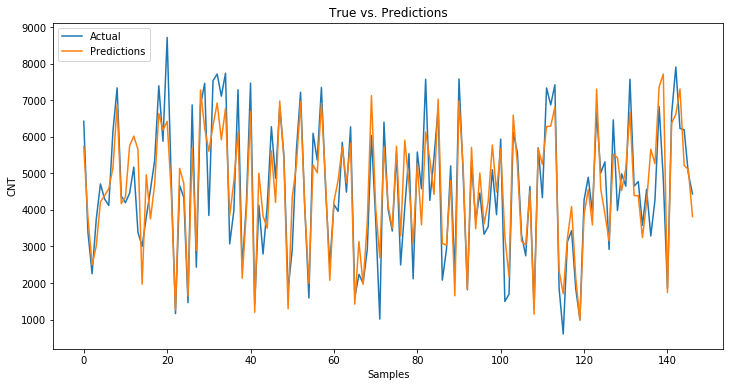

In [18]:
plt.figure(figsize=(12,6))
plt.plot(y_test)
plt.plot(predictions)
plt.title('True vs. Predictions')
plt.ylabel('CNT')
plt.xlabel('Samples')
plt.legend(['Actual', 'Predictions'], loc='upper left')
plt.show()

## DNN Model

In [19]:
X=X.to_numpy()
X_test2=X_test1.to_numpy()

In [20]:
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

In [21]:
X=X.reshape(X.shape[0],X.shape[1])
X_test2=X_test2.reshape(X_test2.shape[0],X_test2.shape[1])
print('Dimension of the training input is:', X.shape)
print('Dimension of the test input is:', X_test2.shape)

Dimension of the training input is: (584, 8)
Dimension of the test input is: (147, 8)


In [22]:
np.random.seed(123)
tf.random.set_seed(123)
modeldnn=Sequential()
modeldnn.add(Dense(20,activation ='relu',input_dim=8))
modeldnn.add(Dropout(0.5))
modeldnn.add(Dense(20,activation='relu'))
modeldnn.add(Dropout(0.5))
modeldnn.add(Dense(1,activation='linear'))
modeldnn.compile(loss='mse',optimizer='adam',metrics=['mean_squared_error'])
network=modeldnn.fit(X,y_train,epochs=400,validation_split=1/6,batch_size=6,verbose=1) 

Train on 486 samples, validate on 98 samples
Epoch 1/400
486/486 [==============================] - 0s 869us/step - loss: 24381104.8519 - mean_squared_error: 24381104.0000 - val_loss: 22018871.6122 - val_mean_squared_error: 22018870.0000
Epoch 2/400
486/486 [==============================] - 0s 201us/step - loss: 24351721.9136 - mean_squared_error: 24351722.0000 - val_loss: 21963437.5714 - val_mean_squared_error: 21963436.0000
Epoch 3/400
486/486 [==============================] - 0s 189us/step - loss: 24228284.0309 - mean_squared_error: 24228284.0000 - val_loss: 21760900.7143 - val_mean_squared_error: 21760902.0000
Epoch 4/400
486/486 [==============================] - 0s 200us/step - loss: 23878357.5000 - mean_squared_error: 23878350.0000 - val_loss: 21257796.3469 - val_mean_squared_error: 21257798.0000
Epoch 5/400
486/486 [==============================] - 0s 232us/step - loss: 23086180.3519 - mean_squared_error: 23086182.0000 - val_loss: 20316123.9388 - val_mean_squared_error: 2031

Epoch 44/400
486/486 [==============================] - 0s 172us/step - loss: 3721817.8067 - mean_squared_error: 3721819.2500 - val_loss: 1228089.7143 - val_mean_squared_error: 1228089.7500
Epoch 45/400
486/486 [==============================] - 0s 165us/step - loss: 3723273.4340 - mean_squared_error: 3723273.5000 - val_loss: 1206034.0191 - val_mean_squared_error: 1206033.7500
Epoch 46/400
486/486 [==============================] - 0s 171us/step - loss: 3450146.2523 - mean_squared_error: 3450146.5000 - val_loss: 1166916.7526 - val_mean_squared_error: 1166916.6250
Epoch 47/400
486/486 [==============================] - 0s 166us/step - loss: 3936486.3133 - mean_squared_error: 3936486.7500 - val_loss: 1188574.6722 - val_mean_squared_error: 1188574.7500
Epoch 48/400
486/486 [==============================] - 0s 166us/step - loss: 3657251.8850 - mean_squared_error: 3657252.0000 - val_loss: 1201609.3099 - val_mean_squared_error: 1201609.2500
Epoch 49/400
486/486 [============================

486/486 [==============================] - 0s 163us/step - loss: 3556481.3403 - mean_squared_error: 3556480.2500 - val_loss: 987664.3814 - val_mean_squared_error: 987664.2500
Epoch 131/400
486/486 [==============================] - 0s 238us/step - loss: 3415718.3009 - mean_squared_error: 3415718.0000 - val_loss: 978340.7997 - val_mean_squared_error: 978340.8750
Epoch 132/400
486/486 [==============================] - 0s 246us/step - loss: 3927035.9549 - mean_squared_error: 3927037.2500 - val_loss: 1021244.8329 - val_mean_squared_error: 1021244.8125
Epoch 133/400
486/486 [==============================] - 0s 168us/step - loss: 3587327.6211 - mean_squared_error: 3587328.0000 - val_loss: 996154.9611 - val_mean_squared_error: 996155.0000
Epoch 134/400
486/486 [==============================] - 0s 152us/step - loss: 3648209.4306 - mean_squared_error: 3648208.7500 - val_loss: 1031868.7640 - val_mean_squared_error: 1031868.7500
Epoch 135/400
486/486 [==============================] - 0s 148us

486/486 [==============================] - 0s 176us/step - loss: 3625920.8692 - mean_squared_error: 3625920.2500 - val_loss: 955381.0906 - val_mean_squared_error: 955381.0625
Epoch 217/400
486/486 [==============================] - 0s 158us/step - loss: 3816901.4857 - mean_squared_error: 3816900.5000 - val_loss: 987911.1378 - val_mean_squared_error: 987911.1250
Epoch 218/400
486/486 [==============================] - 0s 180us/step - loss: 3641583.3935 - mean_squared_error: 3641583.7500 - val_loss: 929626.4777 - val_mean_squared_error: 929626.5000
Epoch 219/400
486/486 [==============================] - 0s 164us/step - loss: 3516791.7442 - mean_squared_error: 3516792.0000 - val_loss: 922556.7028 - val_mean_squared_error: 922556.6250
Epoch 220/400
486/486 [==============================] - 0s 183us/step - loss: 3817669.6929 - mean_squared_error: 3817669.0000 - val_loss: 921583.5855 - val_mean_squared_error: 921583.6875
Epoch 221/400
486/486 [==============================] - 0s 187us/ste

486/486 [==============================] - 0s 184us/step - loss: 3900006.5737 - mean_squared_error: 3900007.2500 - val_loss: 924262.5153 - val_mean_squared_error: 924262.4375
Epoch 303/400
486/486 [==============================] - 0s 172us/step - loss: 3349202.3480 - mean_squared_error: 3349201.7500 - val_loss: 899985.6626 - val_mean_squared_error: 899985.6250
Epoch 304/400
486/486 [==============================] - 0s 181us/step - loss: 3224818.9117 - mean_squared_error: 3224820.0000 - val_loss: 915100.9751 - val_mean_squared_error: 915101.0000
Epoch 305/400
486/486 [==============================] - 0s 146us/step - loss: 3434937.4552 - mean_squared_error: 3434937.7500 - val_loss: 907941.3119 - val_mean_squared_error: 907941.3750
Epoch 306/400
486/486 [==============================] - 0s 164us/step - loss: 3657644.8503 - mean_squared_error: 3657644.5000 - val_loss: 970477.1320 - val_mean_squared_error: 970477.1250
Epoch 307/400
486/486 [==============================] - 0s 292us/ste

486/486 [==============================] - 0s 175us/step - loss: 3410821.9645 - mean_squared_error: 3410821.7500 - val_loss: 960274.4190 - val_mean_squared_error: 960274.3125
Epoch 389/400
486/486 [==============================] - 0s 171us/step - loss: 3390680.9726 - mean_squared_error: 3390680.7500 - val_loss: 960630.8565 - val_mean_squared_error: 960630.8750
Epoch 390/400
486/486 [==============================] - 0s 173us/step - loss: 3684999.8534 - mean_squared_error: 3684999.2500 - val_loss: 959520.2806 - val_mean_squared_error: 959520.2500
Epoch 391/400
486/486 [==============================] - 0s 174us/step - loss: 3479452.5440 - mean_squared_error: 3479452.5000 - val_loss: 941763.4203 - val_mean_squared_error: 941763.4375
Epoch 392/400
486/486 [==============================] - 0s 175us/step - loss: 3633303.2757 - mean_squared_error: 3633303.5000 - val_loss: 937497.1384 - val_mean_squared_error: 937497.0625
Epoch 393/400
486/486 [==============================] - 0s 190us/ste

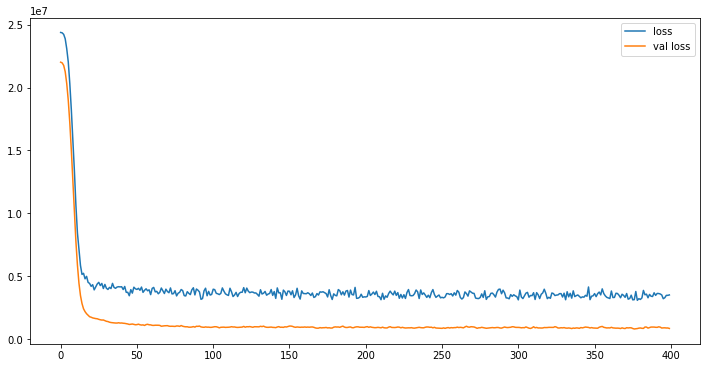

In [23]:
plt.figure(figsize=(12,6))
plt.plot(network.history['loss'],label='loss')
plt.plot(network.history['val_loss'],label='val loss')
plt.legend()
plt.show()

In [24]:
evaval=network.history['val_loss'][399]
print('The rmse for the validation is', sqrt(evaval))

The rmse for the validation is 922.5424475882077


In [25]:
eva=modeldnn.evaluate(X_test2,y_test)
print('The rmse for the test set is', sqrt(eva[1]))

147/147 [==============================] - 0s 54us/step
The rmse for the test set is 988.5746683989025


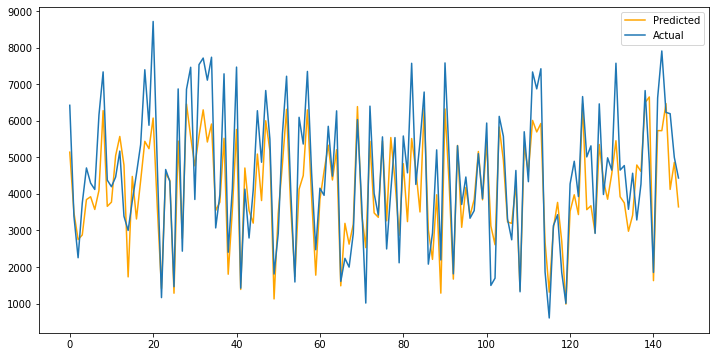

In [26]:
plt.figure(figsize=(12,6))
preds=modeldnn.predict(X_test2)
plt.plot(preds,label='Predicted',color='orange')
plt.plot(y_test,label='Actual')
plt.legend()
plt.show()